In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 8 # batch size

# Import necessary things

In [2]:
%%capture
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7qGgoYy8vkC6wV5bi2zcjBmgg62Fy-TK3LvdUCdS1y-z7rgKPKJ80


In [3]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

# Mount Drive to access the folders

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get download links from Google Chrome Images


Insert the following code in the Javascript console after searching for whatever you want in Google Images. 
```
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



# Download the images

In [ ]:
# This brings out the fastai documentation
doc(download_images)

In [ ]:
folder = 'anime'
file = 'urls/anime.txt'

In [ ]:
folder = 'animation'
file = 'urls/animation.txt'

In [ ]:
folder = 'cgi/cgi'
file = 'urls/cgi.txt'

In [5]:
path = Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data')

In [ ]:
# Making Directories
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

(#4) [Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data/urls'),Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data/animation'),Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data/anime'),Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data/cgi')]

Run it for three different files three times to download the images in the particular file

In [ ]:
# download_images(dest, url_file=path/file)

In [ ]:
classes = ['anime','animation','cgi']

In [ ]:
for c in classes:
    print(c)
    x = verify_images(path/c)

anime
zip argument #1 must support iteration
animation
zip argument #1 must support iteration
cgi
zip argument #1 must support iteration


# Setting up the DataLoaders

In [6]:
path = Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data')
classes = ['anime','animation','cgi']

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # getting 80-20 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))                            # resizing to get the image of same shape

In [8]:
dls = dblock.dataloaders(path,bs=bs) # setting up batch size for efficient GPU use

In [ ]:
doc(dblock.dataloaders)

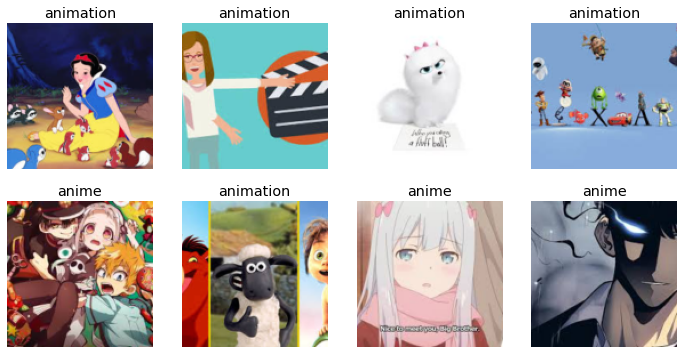

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

# Data Augmentation

In [ ]:
doc(aug_transforms)

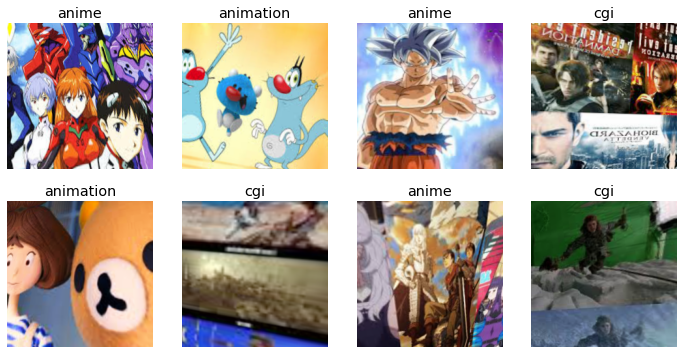

In [9]:
# RandomResizedCrop crops images randomly and create copies so that we don't miss out anything
# aug_transforms is used for image data augmentation
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

# Training and Data Cleaning


In [10]:
model_path = Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/model')

In [11]:
# cnn_learner is the default fastai learner for convnets
learn = cnn_learner(dls, resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# SaveModelCallback is fastai default callback function to save the trained model
learn.fine_tune(5,cbs=SaveModelCallback(fname=model_path/'anime-classifier'))

Better model found at epoch 0 with valid_loss value: 0.8059573769569397.


Better model found at epoch 0 with valid_loss value: 1.282091736793518.
Better model found at epoch 2 with valid_loss value: 1.0452029705047607.


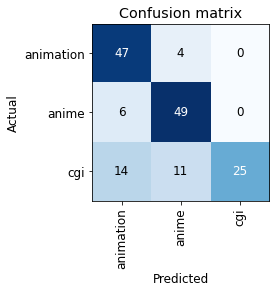

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

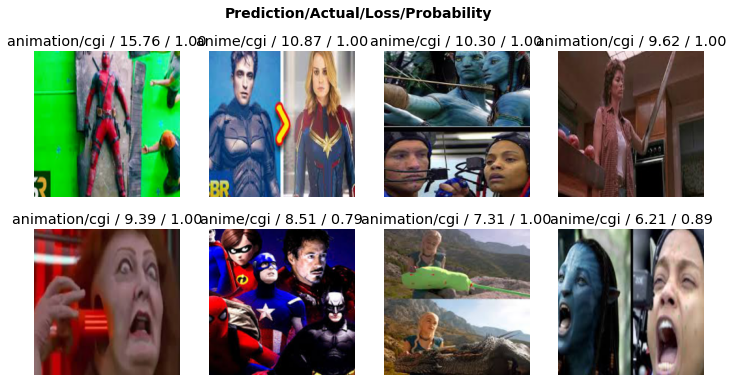

In [ ]:
interp.plot_top_losses(8, nrows=2)

In [ ]:
doc(ImageClassifierCleaner)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()                            # delete irrelevant data
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat/cat) # change the directory

## Loading the Trained Model

In [12]:
learn.load(model_path/'anime-classifier')
learn

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


## Setting up the model for inference

In [13]:
learn.export(model_path/'anime-classifier.pkl')

In [14]:
img_path = Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/data/test_images')
inf_path = Path('/content/drive/My Drive/Colab Notebooks/Learning Projects/Anime vs Animation vs CGI/model')

In [15]:
learn_inf = load_learner(inf_path/'anime-classifier.pkl')

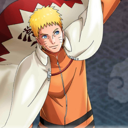

In [25]:
img = Image.open(img_path/'naruto.png')
img.to_thumb(128,128)

In [21]:
learn_inf.predict(img_path/'naruto.png')

('anime', tensor(1), tensor([1.5762e-05, 9.9998e-01, 7.4546e-07]))

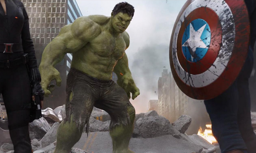

In [28]:
img = Image.open(img_path/'hulk.png')
img.to_thumb(256,256)

In [24]:
learn_inf.predict(img_path/'hulk.png')

('cgi', tensor(2), tensor([0.1133, 0.0041, 0.8826]))

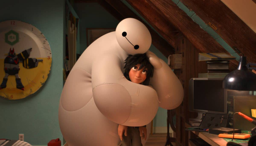

In [31]:
img = Image.open(img_path/'bh6.jpg')
img.to_thumb(256,256)

In [32]:
learn_inf.predict(img_path/'bh6.jpg')

('animation', tensor(0), tensor([9.9998e-01, 3.5907e-07, 1.8467e-05]))